<a href="https://colab.research.google.com/github/irenewuuuu/Video-view-time/blob/main/031923_Amazon_prime_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: set up enviroment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt



# Part 0.1: load data

In [ ]:
# load data from google drive, install pydrive to load data, below coding blocks are provided by google

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# save tv data in google drive, update the accessibility to anyone and then get the link, ID is included in the link
# https://drive.google.com/file/d/1emi9wZVx3Xq5cjv8xSZC0O9qUPqGTohf/view?usp=share_link
id = "1emi9wZVx3Xq5cjv8xSZC0O9qUPqGTohf"
file = drive.CreateFile({'id':id})
file.GetContentFile('tv_data.txt')

In [ ]:
tv = pd.read_csv('tv_data.txt')

# Part 1: Explore data
* feature amount
* observation amount
* missing value
* duplicate value
* categorical feature, numerical feature
* EDA


In [ ]:
# preliminary look of what's in the table
tv.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.605608,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.5,112.301017,51,other award,PG-13,1.710000
1,300175,270338.426375,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.5,94.983250,41,no award,R,3.250000
2,361899,256165.867446,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.3,115.763675,58,other award,R,2.646667
3,308314,196622.720996,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.6,130.703583,94,Oscar,R,1.666667
4,307201,159841.652064,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.4,105.545533,37,other award,R,3.066667


* imdb_votes, the number of votes on IMDB, the higher the better
* mpaa: mpaa ratings 评级
* awards: tvpg ratings
* import_id: content partners
* metacritic_score: metacritic scores on IMDB page, typically the higher the better
* star_category: **a score to measure how popular the actor/actress are associated with the movie.**?


In [ ]:
# basic info of the table, number of observations, features, feature type
tv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

* 4226 observations, 16 features, no null value
* id of movie has no meaning, can drop
* import_id is realted to production company, maybe some company has better quality of movie, so keep this feature.

**rename**

In [ ]:
# # replacing 'weighted_categorical_position' to 'c_position'
# tv = tv.rename(columns={'weighted_categorical_position':'c_position'})
# # replacing 'weighted_horizontal_poition' to 'h_position'
# tv = tv.rename(columns={'weighted_horizontal_poition':'h_position'})
# # replacing 'release_year' to 'year'
# tv = tv.rename(columns={'release_year':'year'})

tv = tv.rename(index=str, columns = {'weighted_categorical_position':'c_position','weighted_horizontal_poition':'h_position','release_year':'year'})



In [ ]:
tv.head()

,video_id,cvt_per_day,c_position,h_position,import_id,year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.605608,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.5,112.301017,51,other award,PG-13,1.710000
1,300175,270338.426375,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.5,94.983250,41,no award,R,3.250000
2,361899,256165.867446,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.3,115.763675,58,other award,R,2.646667
3,308314,196622.720996,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.6,130.703583,94,Oscar,R,1.666667
4,307201,159841.652064,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.4,105.545533,37,other award,R,3.066667


* dependent variable: cvt_per_day, the value we want to predict
* feature to drop: video id
* categorical features:
** release year, object, but come as int, 1916-2017,considering bin the year
** import_id, onehot encoding
** genre, onehot encoding
** awards, mpaa, label encoding
* numerical features:
** imdb votes, budget, box office, vary too much, consider normalize to convert all the values to within [0:1]. why not standardize? standardize may have negative value, which looks weird.


**check unique value**

In [ ]:
# checking unique value
print('***Count of nunique values***')
print(tv.nunique())

***Count of nunique values***
video_id            4226
cvt_per_day         4226
c_position            37
h_position            68
import_id              4
year                  97
genres              1165
imdb_votes          2282
budget               253
boxoffice            410
imdb_rating           85
duration_in_mins    4097
metacritic_score      90
awards                 5
mpaa                   6
star_category        630
dtype: int64


**duplicated observations**

**drop feature**

In [ ]:
# drop irrelevant features
tv_1 = tv.drop(['video_id'], axis = 1)
tv_1.head()

,cvt_per_day,c_position,h_position,import_id,year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,307127.605608,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.5,112.301017,51,other award,PG-13,1.710000
1,270338.426375,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.5,94.983250,41,no award,R,3.250000
2,256165.867446,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.3,115.763675,58,other award,R,2.646667
3,196622.720996,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.6,130.703583,94,Oscar,R,1.666667
4,159841.652064,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.4,105.545533,37,other award,R,3.066667


In [ ]:
# extract duplicated row
tv_1[tv_1.duplicated()]

,cvt_per_day,c_position,h_position,import_id,year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category


each video should only appear once in the list, duplicated video will be removed

In [ ]:
if tv['video_id'].duplicated().sum()==0:
  print('no duplicated index')

no duplicated index


no duplicated value

In [ ]:
numerical = ['cvt_per_day','c_position','h_position','imdb_votes','budget','boxoffice','imdb_rating','duration_in_mins','metacritic_score','star_category']
categorical = ['import_id','year','genres','awards','mpaa']


## understand numerical features

In [ ]:
# check missing value
tv_1.isnull().sum()

cvt_per_day         0
c_position          0
h_position          0
import_id           0
year                0
genres              0
imdb_votes          0
budget              0
boxoffice           0
imdb_rating         0
duration_in_mins    0
metacritic_score    0
awards              0
mpaa                0
star_category       0
dtype: int64

In [ ]:
tv_1.isna().sum()

cvt_per_day         0
c_position          0
h_position          0
import_id           0
year                0
genres              0
imdb_votes          0
budget              0
boxoffice           0
imdb_rating         0
duration_in_mins    0
metacritic_score    0
awards              0
mpaa                0
star_category       0
dtype: int64

what's difference between isna and In pandas, isna() and isnull() are two methods that are used to check for missing or null values in a DataFrame or Series. Both methods essentially perform the same function of detecting null or missing values in the data.

no null value, but does not necessarily mean no missing value, some value might not be appropirate, see below.

In [ ]:
tv_1.describe(percentiles=[0.1,0.25,0.5,0.75,0.95])

,cvt_per_day,c_position,h_position,year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03,4226.000000,4226.000000,4226.000000,4226.000000
mean,4218.630239,7.782537,28.103644,2001.056791,6462.924042,2.150743e+06,2.536338e+06,5.257099,89.556123,15.973734,0.954651
std,13036.079964,6.134183,11.863649,17.496849,31596.006790,7.176604e+06,8.243516e+06,2.122810,21.086183,26.205217,0.955045
min,2.187625,1.000000,1.000000,1916.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,4.037250,0.000000,0.000000
10%,141.984913,3.000000,13.000000,1974.000000,8.000000,0.000000e+00,0.000000e+00,2.300000,62.390781,0.000000,0.000000
25%,351.168776,4.000000,20.000000,1998.000000,81.000000,0.000000e+00,0.000000e+00,4.300000,82.601712,0.000000,0.000000
50%,1193.499989,6.000000,28.000000,2008.000000,535.000000,0.000000e+00,0.000000e+00,5.800000,90.730308,0.000000,1.000000
75%,3356.788816,9.000000,36.000000,2012.000000,3053.000000,1.500000e+06,0.000000e+00,6.800000,99.500312,41.000000,1.666667
95%,14692.833929,22.000000,48.000000,2015.000000,26199.500000,1.200000e+07,8.551228e+06,7.800000,119.131183,65.000000,2.597222
max,307127.605608,41.000000,70.000000,2017.000000,948630.000000,1.070000e+08,1.842088e+08,10.000000,246.016767,100.000000,4.000000


note, 50% of movie have zero budget or box office, which must be something missing. will deal with missing value in part 2 feature processing

**cvt_per_day feature**

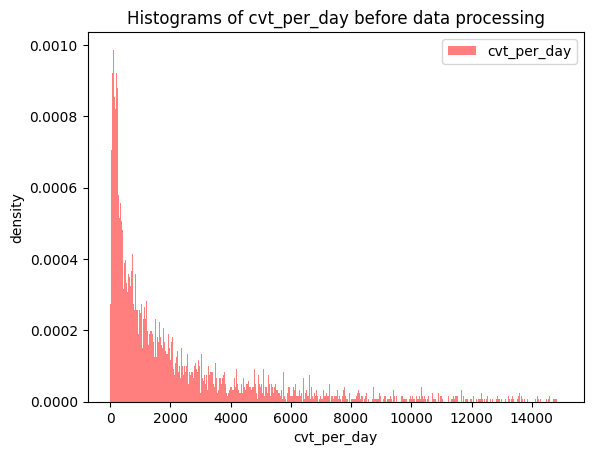

In [ ]:
# 95%of data is below 150000 per above overview
plt.hist(tv['cvt_per_day'],bins=range(0,15000,30),color='r',label='cvt_per_day',density=True, alpha=0.5) # density=True, 不加这句就是整数，加了之后是概率
plt.title('Histograms of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

### correlation among numerical features

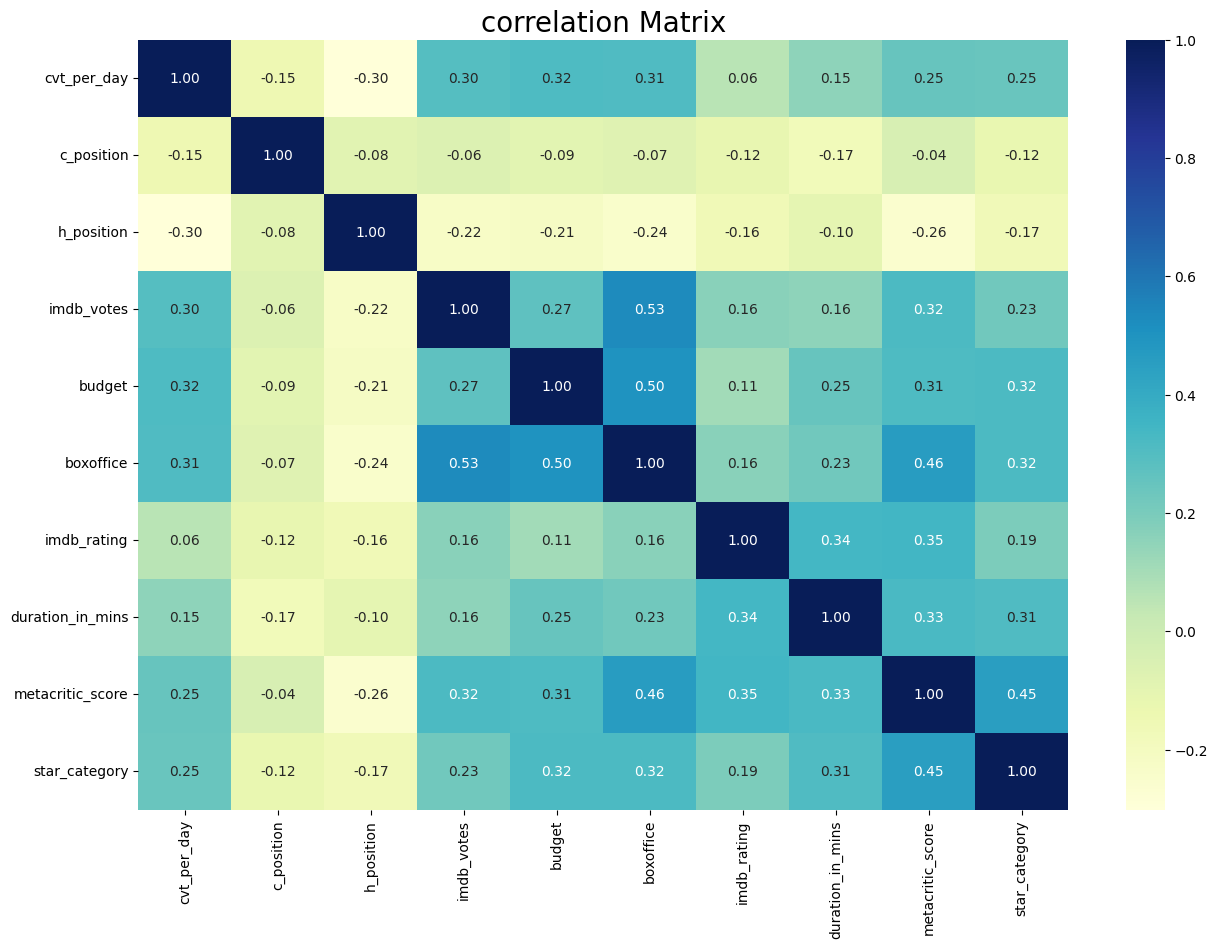

In [ ]:
# pearson correlation, do remember the formula
# do calculate pearson correlation
# while, most of the time, do not need to remove features just base on pearson correlation, except, highly correlated
f,ax=plt.subplots(figsize=[15,10])
sns.heatmap(tv_1[numerical].corr(),annot = True, fmt=".2f", ax=ax, cmap="YlGnBu")
ax.set_title("correlation Matrix", fontsize = 20)
plt.show()

In [ ]:
corr = pd.DataFrame(tv_1[numerical].corr()['cvt_per_day'].sort_values(ascending=False))
corr = corr.iloc[1:,:]
corr.columns=['Target Correlation']
corr


,Target Correlation
budget,0.315886
boxoffice,0.312209
imdb_votes,0.297697
metacritic_score,0.249159
star_category,0.246956
duration_in_mins,0.152217
imdb_rating,0.058894
c_position,-0.148000
h_position,-0.301663


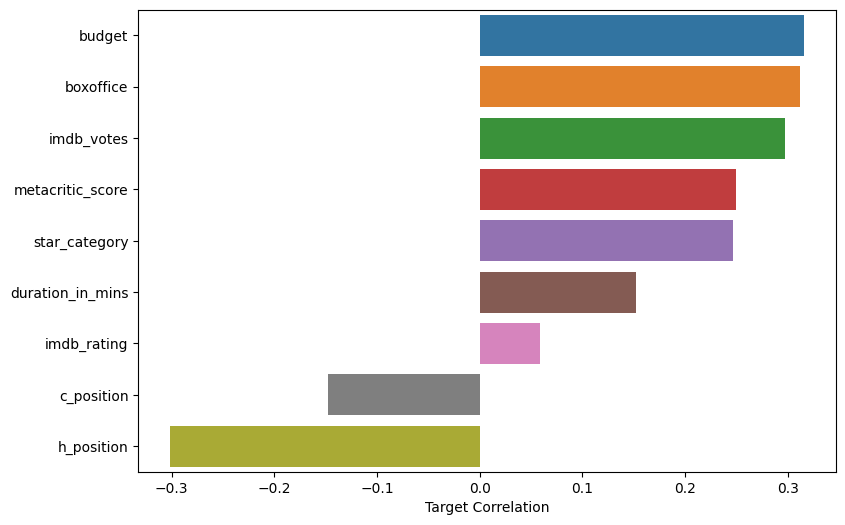

In [ ]:
g0=sns.barplot(x='Target Correlation', y=corr.index, data=corr)
g0.figure.set_size_inches(9,6)

## understand categorical features
* categorical = ['import_id','year','genres','awards','mpaa']

### distribution of standard categorical features

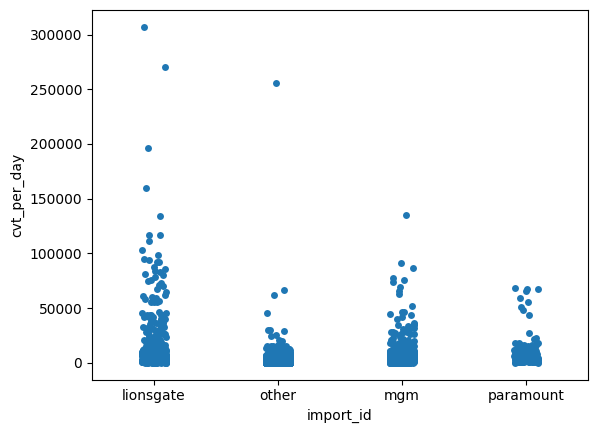

other        2963
lionsgate     677
mgm           445
paramount     141
Name: import_id, dtype: int64


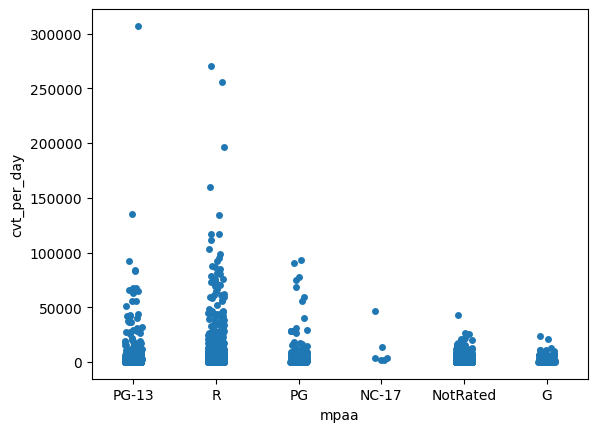

NotRated    2158
R           1158
PG-13        426
PG           353
G            125
NC-17          6
Name: mpaa, dtype: int64


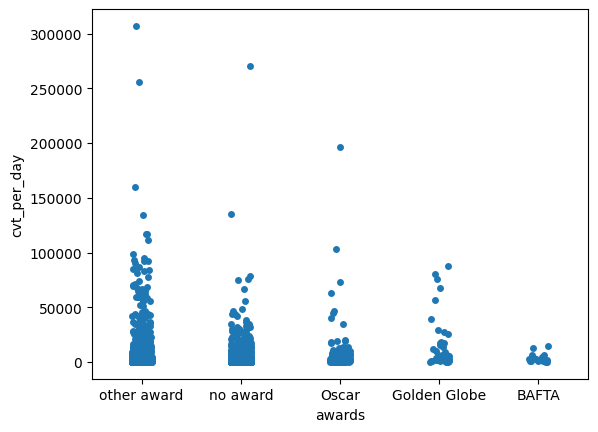

no award        2569
other award     1453
Oscar            141
Golden Globe      44
BAFTA             19
Name: awards, dtype: int64


In [ ]:
sns.stripplot(x='import_id',y='cvt_per_day',data=tv_1, jitter=True)
plt.show()
print(tv_1['import_id'].value_counts())

sns.stripplot(x='mpaa',y='cvt_per_day',data=tv_1, jitter=True)
plt.show()
print(tv_1['mpaa'].value_counts())

sns.stripplot(x='awards',y='cvt_per_day',data=tv_1, jitter=True)
plt.show()
print(tv_1['awards'].value_counts())

### distribution of splited genres
* some movies belong to several genres, split to better identify which genres is more popular
* group the genres with lower than 100 count as others, cause there is not enough data point, no meaning/statistic significance to analysis/modeling
* get_dummies: one hot encoding
* get_dummies(sep=""), split then one hot encoding

In [ ]:
gen_split = tv_1['genres'].str.get_dummies(sep=",")
gen_split

,Action,Adult,Adventure,Animation,Anime,Comedy,Crime,Documentary,Drama,Fantasy,...,Music,Musicals,Mystery,Reality,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,1,0
4,0,0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4222,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4223,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4224,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
gen_split.sum().sort_values(ascending=False)

Drama                    1677
Comedy                   1184
Thriller                  879
Horror                    762
Action                    739
Documentary               671
Romance                   591
Crime                     437
Independent               393
Mystery                   375
Adventure                 363
Sci-Fi                    363
Kids & Family             280
Fantasy                   243
Music                     171
Animation                 129
War                       102
Western                   102
Sport                      77
Musicals                   68
Foreign/International      64
Anime                      11
Reality                     9
Lifestyle                   7
Adult                       3
LGBT                        2
Holiday                     1
dtype: int64

<Axes: >

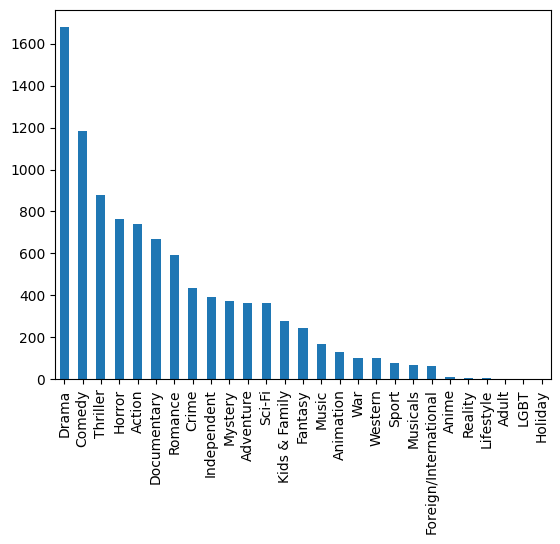

In [ ]:
gen_split.sum().sort_values(ascending=False).plot.bar()

### distribution of release year
* the release year of video varis from 1916-2017
* more movies were released in recent year
* considering the popularity of a video usually decays over time, the release_year should be buketed based on release_year range
* year should be treated as categorical feature, usually we make sure the number of movie in each bucket (period) is similar


<function matplotlib.pyplot.show(close=None, block=None)>

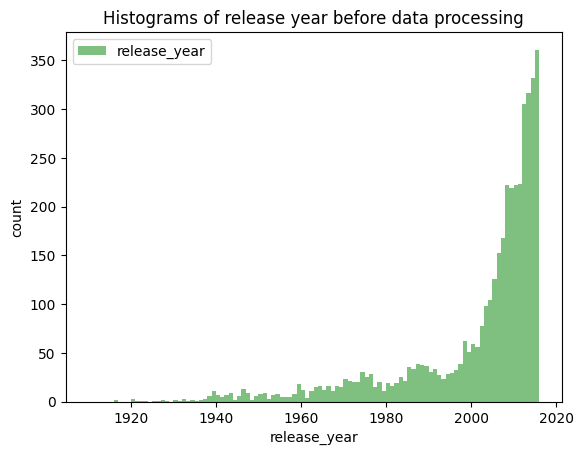

In [ ]:
plt.hist(tv_1['year'].values, bins=range(1910,2017,1), alpha = 0.5, color='g', label='release_year')
plt.legend(loc='upper left')
plt.title('Histograms of release year before data processing')
plt.xlabel('release_year')
plt.ylabel('count')
plt.show

# Part 2: feature processing

## categorical feature processing
* including: import_id, mpaa, awards, genres, year.
* no missing data
* one hot encoding
* year: bined into 10 buckets with similar number of movies in each bucket
* genre: group the genres with less than 100 count into 'others' category, then one hot encoding


In [ ]:
categorical

['import_id', 'year', 'genres', 'awards', 'mpaa']

In [ ]:
# convert import_id, mpaa, awards into dummy variables
d_import_id = pd.get_dummies(tv_1['import_id']).astype(np.int64) # no need to add astype(np.int64), just add this to make sure it is int
d_awards = pd.get_dummies(tv_1['awards'])
d_mpaa = pd.get_dummies(tv_1['mpaa'])


### sklearn onehotencoder vs. pandas.get_dummies
Both Scikit-learn's OneHotEncoder and Pandas' get_dummies are used for one-hot encoding categorical variables. One-hot encoding is a process of converting categorical variables into a numerical representation that can be used in machine learning algorithms.

However, there are some differences between OneHotEncoder and get_dummies that are worth noting:

Implementation: OneHotEncoder is part of Scikit-learn, while get_dummies is part of Pandas. This means that OneHotEncoder is typically used within a Scikit-learn machine learning pipeline, while get_dummies is used within Pandas data manipulation.
Input type: OneHotEncoder expects a 2D array-like input, while get_dummies expects a Pandas DataFrame or Series input.
Handling unseen categories: OneHotEncoder requires you to specify what to do with new categories not seen in the training data by setting the handle_unknown parameter. get_dummies, on the other hand, by default creates a new column with all zeros for unseen categories in the test set.
Output type: **OneHotEncoder returns a sparse matrix by default, which can be memory-efficient for large datasets with many categories. get_dummies, by default, returns a dense DataFrame, which can be memory-intensive for large datasets with many categories.**
Column names: get_dummies returns a DataFrame with column names that include the original categorical column name and the category name, separated by an underscore. OneHotEncoder does not have this functionality built-in and requires additional steps to create column names.

to sumup, onehotencoder，用在ML pipelines，更专业，对于大数据来讲output更加节省空间，pandas.get_dummies主要用于pandas对于dataframe的manipulation。output需要空间更大。

In [ ]:
d_genres=tv_1['genres'].str.get_dummies(sep=',')
d_genres['others']=d_genres['Sport']|d_genres['Musicals']|d_genres['Foreign/International']|d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Musicals','Sport','Foreign/International','Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'],inplace=True, axis=1)

In [ ]:
d_genres

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Independent,Kids & Family,Music,Mystery,Romance,Sci-Fi,Thriller,War,Western,others
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4222,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4223,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4224,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
tv_1['year'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

0.1    1974.0
0.2    1991.0
0.3    2001.0
0.4    2006.0
0.5    2008.0
0.6    2010.0
0.7    2012.0
0.8    2013.0
0.9    2014.0
Name: year, dtype: float64

In [ ]:
# bin release year and conver into dummies
bin_year = [1916,1974,1991,2001,2006,2008,2010,2012,2013,2014,2017]
year_range=['1916-1974','1974-1991','1991-2001','2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
            '2013-2014','2014-2017']
year_bin = pd.cut(tv_1['year'],bin_year,labels=year_range)
d_year=pd.get_dummies(year_bin).astype(np.int64)

In [ ]:
#drop previous categorical features and add new dummy variables, check for null
tv_temp=tv_1.drop(['import_id','year','mpaa','awards','genres'],axis=1)
tv_2 = pd.concat([tv_temp,d_import_id,d_awards,d_genres,d_mpaa,d_year],axis=1)

In [ ]:
tv_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4226 entries, 0 to 4225
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cvt_per_day       4226 non-null   float64
 1   c_position        4226 non-null   int64  
 2   h_position        4226 non-null   int64  
 3   imdb_votes        4226 non-null   int64  
 4   budget            4226 non-null   int64  
 5   boxoffice         4226 non-null   int64  
 6   imdb_rating       4226 non-null   float64
 7   duration_in_mins  4226 non-null   float64
 8   metacritic_score  4226 non-null   int64  
 9   star_category     4226 non-null   float64
 10  lionsgate         4226 non-null   int64  
 11  mgm               4226 non-null   int64  
 12  other             4226 non-null   int64  
 13  paramount         4226 non-null   int64  
 14  BAFTA             4226 non-null   uint8  
 15  Golden Globe      4226 non-null   uint8  
 16  Oscar             4226 non-null   uint8  
 17  

## numerical features processing

In [ ]:
numerical

['cvt_per_day',
 'c_position',
 'h_position',
 'imdb_votes',
 'budget',
 'boxoffice',
 'imdb_rating',
 'duration_in_mins',
 'metacritic_score',
 'star_category']

In [ ]:
tv_2[numerical].describe(percentiles=[0.1,0.25,0.5,0.75,0.95])

,cvt_per_day,c_position,h_position,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.000000,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03,4226.000000,4226.000000,4226.000000,4226.000000
mean,4218.630239,7.782537,28.103644,6462.924042,2.150743e+06,2.536338e+06,5.257099,89.556123,15.973734,0.954651
std,13036.079964,6.134183,11.863649,31596.006790,7.176604e+06,8.243516e+06,2.122810,21.086183,26.205217,0.955045
min,2.187625,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,4.037250,0.000000,0.000000
10%,141.984913,3.000000,13.000000,8.000000,0.000000e+00,0.000000e+00,2.300000,62.390781,0.000000,0.000000
25%,351.168776,4.000000,20.000000,81.000000,0.000000e+00,0.000000e+00,4.300000,82.601712,0.000000,0.000000
50%,1193.499989,6.000000,28.000000,535.000000,0.000000e+00,0.000000e+00,5.800000,90.730308,0.000000,1.000000
75%,3356.788816,9.000000,36.000000,3053.000000,1.500000e+06,0.000000e+00,6.800000,99.500312,41.000000,1.666667
95%,14692.833929,22.000000,48.000000,26199.500000,1.200000e+07,8.551228e+06,7.800000,119.131183,65.000000,2.597222
max,307127.605608,41.000000,70.000000,948630.000000,1.070000e+08,1.842088e+08,10.000000,246.016767,100.000000,4.000000


### missing values
even though there is no null value in our dataset, but we noticed that there are at least 50% of movies with zero budget or box office, which is not possible in reality. imdb_votes and imdb_rating has less than 10% of missing data.

In [ ]:
# replace zero with null and then use fillna()
tv_2[numerical]=tv_2[numerical].replace(0,np.nan)

In [ ]:
tv_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4226 entries, 0 to 4225
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cvt_per_day       4226 non-null   float64
 1   c_position        4226 non-null   int64  
 2   h_position        4226 non-null   int64  
 3   imdb_votes        3882 non-null   float64
 4   budget            1772 non-null   float64
 5   boxoffice         1032 non-null   float64
 6   imdb_rating       3882 non-null   float64
 7   duration_in_mins  4226 non-null   float64
 8   metacritic_score  1214 non-null   float64
 9   star_category     2380 non-null   float64
 10  lionsgate         4226 non-null   int64  
 11  mgm               4226 non-null   int64  
 12  other             4226 non-null   int64  
 13  paramount         4226 non-null   int64  
 14  BAFTA             4226 non-null   uint8  
 15  Golden Globe      4226 non-null   uint8  
 16  Oscar             4226 non-null   uint8  
 17  

fill na with mean value. or can also try medium value to see which one performs better. for takehome challenge, can just choose one. but i think medium is better cause, the data is skewed. use median() to fill null with median of each numerical feature that has missing value:
**imdb_votes, budget, boxoffice, imdb_rating, metacritic_score, star_category **

In [ ]:
tv_3=tv_2.copy()

In [ ]:
tv_3['imdb_votes']=tv_3['imdb_votes'].fillna(tv_3['imdb_votes'].median())
tv_3['budget']=tv_3['budget'].fillna(tv_3['budget'].median())
tv_3['boxoffice']=tv_3['boxoffice'].fillna(tv_3['boxoffice'].median())
tv_3['imdb_rating']=tv_3['imdb_rating'].fillna(tv_3['imdb_rating'].median())
tv_3['metacritic_score']=tv_3['metacritic_score'].fillna(tv_3['metacritic_score'].median())
tv_3['star_category']=tv_3['star_category'].fillna(tv_3['star_category'].median())

In [ ]:
tv_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4226 entries, 0 to 4225
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cvt_per_day       4226 non-null   float64
 1   c_position        4226 non-null   int64  
 2   h_position        4226 non-null   int64  
 3   imdb_votes        4226 non-null   float64
 4   budget            4226 non-null   float64
 5   boxoffice         4226 non-null   float64
 6   imdb_rating       4226 non-null   float64
 7   duration_in_mins  4226 non-null   float64
 8   metacritic_score  4226 non-null   float64
 9   star_category     4226 non-null   float64
 10  lionsgate         4226 non-null   int64  
 11  mgm               4226 non-null   int64  
 12  other             4226 non-null   int64  
 13  paramount         4226 non-null   int64  
 14  BAFTA             4226 non-null   uint8  
 15  Golden Globe      4226 non-null   uint8  
 16  Oscar             4226 non-null   uint8  
 17  

In [ ]:
tv_3[numerical].describe(percentiles=[0.1,0.25,0.5,0.75,0.95])

,cvt_per_day,c_position,h_position,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.000000,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03,4226.000000,4226.000000,4226.000000,4226.000000
mean,4218.630239,7.782537,28.103644,6517.706815,3.021780e+06,8.999335e+06,5.737364,89.556123,56.599385,1.682684
std,13036.079964,6.134183,11.863649,31585.332662,6.950107e+06,6.975854e+06,1.434939,21.086183,7.341360,0.453063
min,2.187625,1.000000,1.000000,5.000000,1.000000e+00,1.316000e+03,1.000000,4.037250,1.000000,1.000000
10%,141.984913,3.000000,13.000000,38.000000,5.000000e+05,8.551228e+06,3.600000,62.390781,57.000000,1.000000
25%,351.168776,4.000000,20.000000,165.000000,1.500000e+06,8.551228e+06,4.900000,82.601712,57.000000,1.575000
50%,1193.499989,6.000000,28.000000,673.000000,1.500000e+06,8.551228e+06,5.900000,90.730308,57.000000,1.666667
75%,3356.788816,9.000000,36.000000,3053.000000,1.500000e+06,8.551228e+06,6.800000,99.500312,57.000000,1.666667
95%,14692.833929,22.000000,48.000000,26199.500000,1.200000e+07,8.551228e+06,7.800000,119.131183,65.000000,2.597222
max,307127.605608,41.000000,70.000000,948630.000000,1.070000e+08,1.842088e+08,10.000000,246.016767,100.000000,4.000000


### feature scaling
two most popular: normalization, standardization, besure to understand how to calculate each other, can try both to see which model perfoms better.
* some model will need feature scaling, some not (random forest), scale first, which is good practice.
* scaling before data split might cause, information leakage, but when data number is huge, then scale before or after split the result will be very similar, so if time is limited, just scale and then split. well, split and scale, will not be time consuming though, just keep this good practice, split and then scale

In [ ]:
tv_sc = tv_3.copy()

In [ ]:
sc_scale = sl.preprocessing.StandardScaler().fit(tv_sc[numerical])


In [ ]:
tv_sc[numerical] = sc_scale.transform(tv_sc[numerical])

In [ ]:
tv_sc.head()

,cvt_per_day,c_position,h_position,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,...,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,23.238951,-1.105826,-2.116264,1.997882,1.723662,4.864658,0.531539,1.078791,-0.762808,0.060300,...,0,0,0,0,0,0,0,1,0,0
1,20.416512,-1.105826,-2.116264,1.272491,1.723662,-0.816956,0.531539,0.257409,-2.125115,3.459786,...,0,0,0,0,0,0,0,1,0,0
2,19.329204,-1.105826,-2.116264,6.050305,3.306559,4.071375,1.089120,1.243025,0.190807,2.127953,...,0,0,0,0,0,0,1,0,0,0
3,14.761098,-0.779746,-2.031963,11.076745,1.723662,0.960665,1.298213,1.951625,5.095111,-0.035357,...,0,0,0,0,1,0,0,0,0,0
4,11.939282,-1.105826,-2.116264,1.272966,3.482116,-0.064244,0.461842,0.758378,-2.670037,3.055086,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Second way of scaling, MinMax scaling or normalization
# newTV_mm = newTV.copy()
# mm_scale = preprocessing.MinMaxScaler().fit(newTV_mm[scale_lst])
# newTV_mm[scale_lst] = mm_scale.transform(newTV_mm[scale_lst])

# Part 3: model training

In [ ]:
# set up enviroment
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt

## data split

In [ ]:
train, test = train_test_split(tv_sc, test_size = 0.2, random_state=2) # random seed, be sure to fix random seed, in order to make sure everytime you run this code, data split would be the same
model_train_x = train.drop(['cvt_per_day'], axis=1)
model_test_x = test.drop(['cvt_per_day'], axis=1)
model_train_y=train['cvt_per_day']
model_test_y=test['cvt_per_day']

## Ridge linear regression

In [ ]:
# further split training data for cross validation
lr_train, lr_validate = train_test_split(train, test_size=0.2, random_state=1)
lr_train_x = lr_train.drop(['cvt_per_day'], axis=1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_x = lr_validate.drop(['cvt_per_day'], axis=1)
lr_validate_y = lr_validate['cvt_per_day']

In [ ]:
ridge=Ridge()
param_grid = {
    'alpha': np.linspace(150,300, num=500) # alpha is lamda, the hyperparmeter for the penalty item
}
grid_ridge=GridSearchCV(estimator=ridge, param_grid=param_grid, scoring = 'neg_mean_squared_error', cv=5)
grid_ridge.fit(lr_train_x, lr_train_y)



GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([150.        , 150.3006012 , 150.6012024 , 150.90180361,
       151.20240481, 151.50300601, 151.80360721, 152.10420842,
       152.40480962, 152.70541082, 153.00601202, 153.30661323,
       153.60721443, 153.90781563, 154.20841683, 154.50901804,
       154.80961924, 155.11022044, 155.41082164, 155.71142285,
       156.01202405, 156.31262525, 156.6132264...
       291.88376754, 292.18436874, 292.48496994, 292.78557114,
       293.08617234, 293.38677355, 293.68737475, 293.98797595,
       294.28857715, 294.58917836, 294.88977956, 295.19038076,
       295.49098196, 295.79158317, 296.09218437, 296.39278557,
       296.69338677, 296.99398798, 297.29458918, 297.59519038,
       297.89579158, 298.19639279, 298.49699399, 298.79759519,
       299.09819639, 299.3987976 , 299.6993988 , 300.        ])},
             scoring='neg_mean_squared_error')

In [ ]:
grid_ridge.score(lr_validate_x,lr_validate_y)

-0.9708891899707431

In [ ]:
a= grid_ridge.best_params_['alpha']

another ridgeCV package

In [ ]:
from sklearn.linear_model import RidgeCV

In [ ]:
ridge_cv = RidgeCV(alphas = [100,150,200])
ridge_cv.fit(lr_train_x, lr_train_y)

RidgeCV(alphas=[100, 150, 200])

In [ ]:
ridge_coefficients = ridge_cv.coef_

In [ ]:
ridge_coefficients

array([-0.08999693, -0.20118037,  0.14331279,  0.13498314,  0.11409852,
       -0.02324766,  0.02180787, -0.06750416,  0.07977168,  0.24661576,
       -0.09835975, -0.15523913,  0.00698312, -0.00570859,  0.03403291,
       -0.08889157, -0.02314998,  0.08371723,  0.05737884, -0.03770975,
       -0.00881717,  0.02813416,  0.05585755, -0.07199239, -0.01881298,
        0.04039109,  0.03568396, -0.0109185 ,  0.05674016,  0.03477941,
       -0.04691822, -0.04837325, -0.02070587,  0.07200831, -0.02219023,
       -0.00229589, -0.0411205 , -0.01214787,  0.00689488, -0.06975035,
        0.00496027,  0.03698151,  0.03306155, -0.05447699, -0.08534258,
       -0.13598256, -0.06662335,  0.05018896,  0.03896093,  0.07194666,
        0.09863723,  0.04331222,  0.04050138])

In [ ]:
ridge_coefficients_df = pd.DataFrame

In [ ]:
# import scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_coefficients = scaler.fit_transform(grid_ridge.coef_.reshape(1,-1))


AttributeError: ignored

In [ ]:
ridge.set_params(alpha=a)

Ridge(alpha=159.0180360721443)

In [ ]:
ridge.fit(model_train_x, model_train_y)

Ridge(alpha=212.82565130260522)

In [ ]:
ridge.score(model_test_x, model_test_y)

NotFittedError: ignored

## Random forest

In [ ]:
rf = RandomForestRegressor(random_state=2, max_features = 'sqrt')
param_grid = {'n_estimators': [55,65,75,85,90,95], 'max_depth':[30,35,40,45]}
rfcv=GridSearchCV(estimator=rf, param_grid=param_grid, scoring = 'neg_mean_squared_error', cv=5)
rfcv.fit(model_train_x, model_train_y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=2),
             param_grid={'max_depth': [30, 35, 40, 45],
                         'n_estimators': [55, 65, 75, 85, 90, 95]},
             scoring='neg_mean_squared_error')

In [ ]:
result=rfcv.cv_results_
print(result)

In [ ]:
rfcv.best_params_

{'max_depth': 30, 'n_estimators': 75}

In [ ]:
rfcv.best_score_

-0.4792714534724336

the bestparameter for max_depth is: 30
the best parameter for n_estimators is: 75


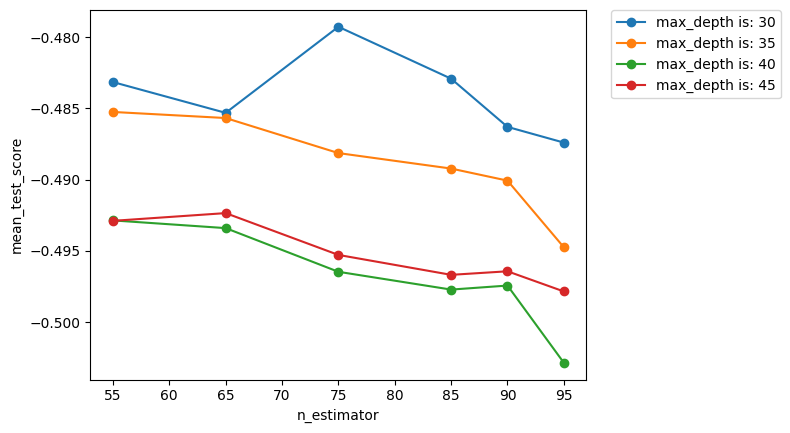

In [ ]:
n_estimators = [55,65,75,85,90,95]
max_depth = [30,35,40,45]
scores=result['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators, scores[i],'-o', label='max_depth is: '+str(j))
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)
plt.xlabel('n_estimator')
plt.ylabel('mean_test_score')
plt.show
print('the bestparameter for max_depth is: '+str(rfcv.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(rfcv.best_params_['n_estimators']))


In [ ]:
FI_rf = pd.DataFrame(rfcv.best_estimator_.feature_importances_, index=model_train_x.columns, columns=['Feature Importance (RF)'])

In [ ]:
FI_rf.sort_values(by='Feature Importance (RF)', ascending = False)

,Feature Importance (RF)
c_position,0.166724
h_position,0.149793
imdb_votes,0.103329
budget,0.062223
boxoffice,0.058518
star_category,0.056891
imdb_rating,0.043485
metacritic_score,0.042605
lionsgate,0.039661
duration_in_mins,0.034292


### permutation importance

In [ ]:
# set the best parrameters from hyper RF perameter tuning
grid_search_best_para = rfcv.best_estimator_
print('Parameters currently in use:\n')
print(grid_search_best_para.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_jobs': None, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}


In [ ]:
# permutation importance
from sklearn.inspection import permutation_importance
PI = permutation_importance(grid_search_best_para, model_test_x, model_test_y, n_repeats = 5, random_state=1)

In [ ]:
PI_res = pd.DataFrame(data = np.transpose([PI['importances_mean'],PI['importances_std']]),
                      index = model_test_x.columns, columns=['PI_mean','PI_std'])
PI_res = PI_res.sort_values(by='PI_mean', ascending=False)
PI_res

,PI_mean,PI_std
h_position,0.161020,0.015957
c_position,0.105768,0.014457
imdb_votes,0.097307,0.017308
lionsgate,0.094453,0.028033
other,0.032686,0.006067
boxoffice,0.026275,0.004984
budget,0.025105,0.003962
duration_in_mins,0.022296,0.006531
mgm,0.015865,0.000693
Thriller,0.013320,0.008605


In [ ]:
pip install shap

In [ ]:
import shap
explainer = shap.Explainer(rfcv)


TypeError: ignored